## Characterize obstacle inputs 
Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
from dw_tap.data_processing import _LatLon_To_XY, filter_obstacles
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

%matplotlib inline
%config InlineBackend.figure_format='retina'

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,Site Type,Site Notes,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy
0,t007,A2719,Fremont,Fremont,MN,43.918622,-91.899498,41,N/A (Legacy Data),NaN,Rural,No lidar data. This turbine is absolutely surr...,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,mn_prairiestar.PROPRIETARY.pruf.csv,43.673,-92.698,50.0,Proprietary
1,t024,A2672,Washoe,Thomas Danzinger,NV,39.331088,-119.820230,30,QL1,2020.0,Rural/Suburban,Straight forward high desert site outside Reno...,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN
2,t028,A3479,Towamensing,Derr,PA,40.851353,-75.598395,30,QL2,2019.0,Suburban,Impressive amount of vegetation – some section...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN
3,t034,A2715,Lycoming,Dan Poor,NY,43.524158,-76.372290,31,QL2,2018.0,Rural,"Lakeshore, heavily forested.",Good coverage,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",ny_oswego.qc.csv,43.464,-76.511,15.0,Public
4,t041,A2272,Rockford,Fossil Park,IA,43.047418,-92.981674,37,QL2,2020.0,Rural,"Very simple site, one building and a couple sm...",Good coverage,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN,NaN


### Select which sites need to be processed and wind data source

In [3]:
# Small test with several sites
#selected = ["t133", "t135"]

# Process all sites:
selected = index["APRS ID"].tolist()

# Remove 2 sites that currently don't have obstacle descriptions with the heights based on lidar data
selected = [x for x in selected if not(x in ["t007", "t074"])]
print(selected)

wind_sources = ["wtk_led_bc"] # One of: ["wtk", "wtk_led_2018", "wtk_led_2019"]

['t024', 't028', 't034', 't041', 't083', 't114', 't133', 't135', 't139', 't140', 't169', 't170', 't182', 't183', 't192', 't207', 't221']


### Test and demonstrate `filter_obstacles()`

In [8]:
sites_with_tall_blgs = [] 

for tid in selected:
    
    index_row = index[index["APRS ID"] == tid].iloc[0]
    z_turbine = index_row["Hub Height (m)"]
    
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    print("Processing: ", obstacle_data_file)
    
    if os.path.exists(obstacle_data_file):
        #print("BEFORE filtering (%s):" % obstacle_data_file)
        #display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(tid,
                                       gpd.read_file(obstacle_data_file), 
                                       include_trees=True, 
                                       turbine_height_for_checking=z_turbine)
        
        if len(obstacle_df[obstacle_df["height"] >= z_turbine]):
             sites_with_tall_blgs.append(tid)
        
        #print("AFTER filtering (%s):" % obstacle_data_file)
        #display(obstacle_df)
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)
    #break
    
print("Sites with tall bldgs (at least as tall as the turbines):", sites_with_tall_blgs)

Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t024v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t028v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t034v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t041v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t083v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t114v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t133v2.json


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:314: UserWarning: (tid: t034) Detected at least 1 obstacle that is as tall as the studied turbine:
       height feature_type                                           geometry
40  41.015999         tree  POLYGON ((-76.37180 43.52360, -76.37171 43.523...
48  39.621994         tree  POLYGON ((-76.37276 43.52496, -76.37280 43.524...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:314: UserWarning: (tid: t133) Detected at least 1 obstacle that is as tall as the studied turbine:
       height feature_type                                           geometry
6   55.354065         tree  POLYGON ((-89.40182 39.32820, -89.40186 39.328...
7   47.110229         tree  POLYGON ((-89.40183 39.32799, -89.40184 39.327...

Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t135v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t139v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t140v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t169v2.json


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:314: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
601  43.349976         tree  POLYGON ((-85.11741 41.07765, -85.11744 41.077

Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t170v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t182v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t183v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t192v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t207v2.json
Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t221v2.json
Sites with tall bldgs (at least as tall as the turbines): ['t034', 't133', 't169', 't170', 't183', 't207']


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:314: UserWarning: (tid: t207) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
600  60.192749     building  POLYGON ((-87.71964 41.48273, -87.71967 41.482...
601  41.273163     building  POLYGON ((-87.71890 41.48356, -87.71900 41.483...
614  54.781128     building  POLYGON ((-87.71809 41.48179, -87.71801 41.482...
759  47.655518         tree  POLYGON ((-87.72349 41.48257, -87.72351 41.482...
765  38.942688         tree  POLYGON ((-87.72415 41.48270, -87.72418 41.482...
773  50.096558         tree  POLYGON ((-87.72254 41.48327, -87.72256 41.483...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \


### Load obstacle data

In [10]:
obstacle_specs = pd.DataFrame(columns=["tid", \
                                       "Number of obstacles", \
                                       "Distance to closest obstacle, m", \
                                       "Height of the closest obstacle, m",
                                       "Site Type"])
for tid in selected:
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    if os.path.exists(obstacle_data_file):
        #display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(tid,
                                       gpd.read_file(obstacle_data_file), 
                                       include_trees=True, 
                                       turbine_height_for_checking=z_turbine)
        
        row = index[index["APRS ID"] == tid].iloc[0]
        lat = row["Latitude"]
        lon = row["Longitude"]
        turbine_point = Point(_LatLon_To_XY(lat, lon))
        stype = row["Site Type"]

        # This will overwrite lat/lon's with coords in meters (for distance calculation)
        for idx, row in obstacle_df.iterrows():
            obstacle_df.at[idx, "geometry"] = Polygon([Point(_LatLon_To_XY(p[1], p[0])) for p in row["geometry"].exterior.coords])
        #display(obstacle_df)
        
        dist_series = obstacle_df.distance(turbine_point)
        min_dist_idx = dist_series.idxmin()
        min_dist_m = dist_series[min_dist_idx]
        closest_obs_height_m = obstacle_df.at[min_dist_idx, "height"]
        
        obstacle_specs.loc[len(obstacle_specs)] = [tid, len(obstacle_df), min_dist_m, closest_obs_height_m, stype]
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)
    #break
display(obstacle_specs)

/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_83069/2056482900.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)
/var/folders/j_/dq5lhppd2jlb45qt4fw_cqth59pwpf/T/ipykernel_83069/2056482900.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_series = obstacle_df.distance(turbine_point)
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:314: UserWarning: (tid: t034) Detected at least 1 obstacle that is as tall as the studied turbine:
       height feature_type                                           geometry
40  41.015999         tree  POLYGON ((-76.37180 43.52360, -76.37171 

,tid,Number of obstacles,"Distance to closest obstacle, m","Height of the closest obstacle, m",Site Type
0,t024,94,7.650585,2.389771,Rural/Suburban
1,t028,174,3.368688,11.662994,Suburban
2,t034,58,11.336468,20.901001,Rural
3,t041,17,40.853890,6.299988,Rural
4,t083,49,28.444797,5.160034,Rural
5,t114,23,15.132590,4.829590,Rural/Suburban
6,t133,17,18.380200,17.100159,Rural
7,t135,14,43.563485,5.119995,Rural
8,t139,18,3.099266,3.429993,Rural
9,t140,272,4.885987,9.590000,Suburban


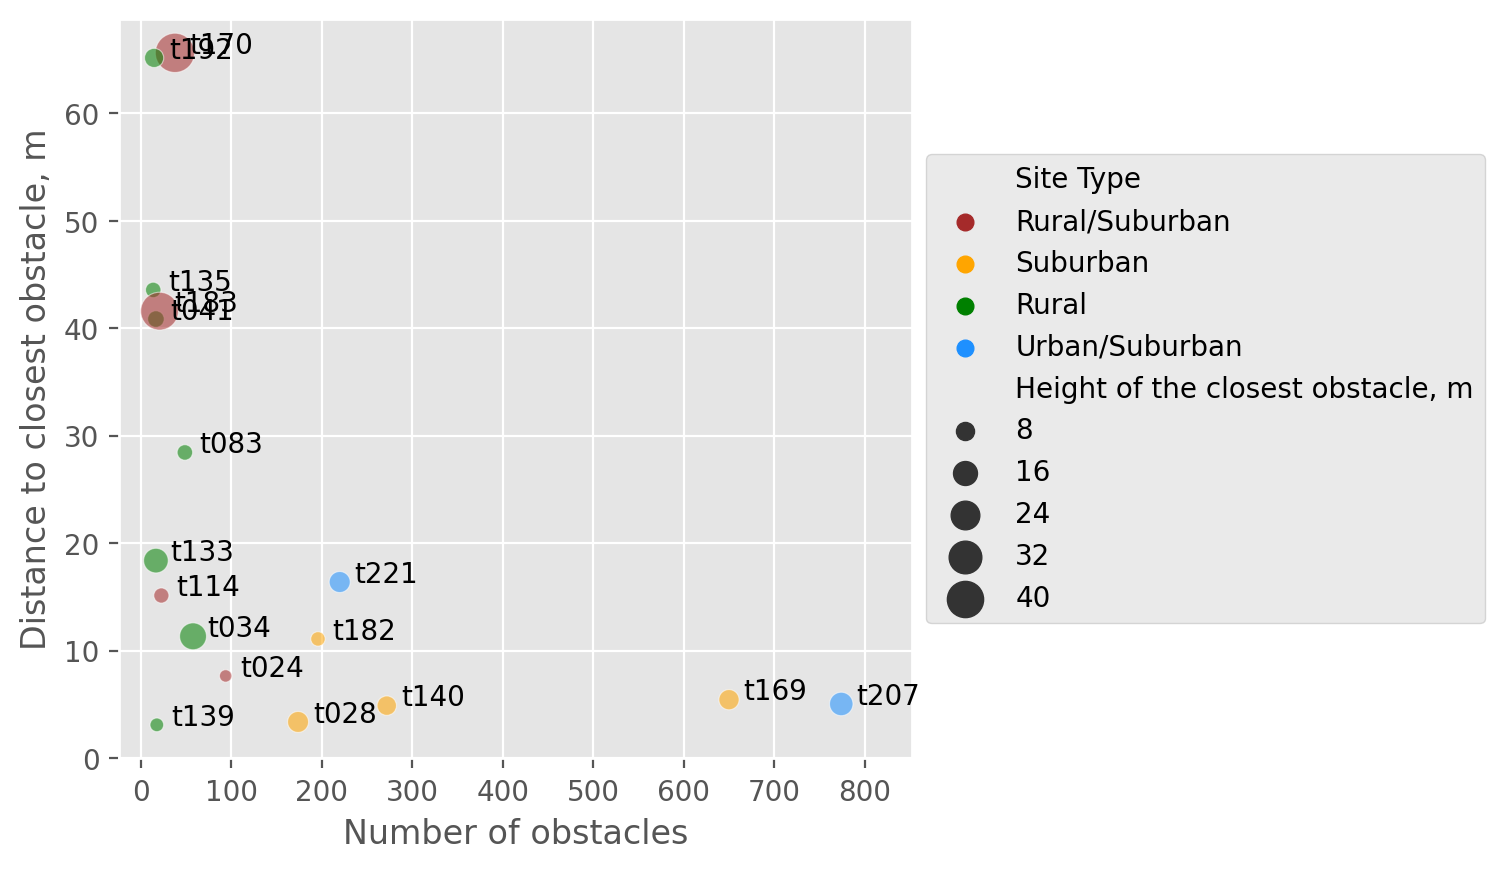

In [6]:
plt.style.use('ggplot')

sns.scatterplot(data=obstacle_specs, \
                x="Number of obstacles", \
                y="Distance to closest obstacle, m",\
                size="Height of the closest obstacle, m",
                sizes=(20, 200),
                hue="Site Type",
                alpha=0.55,
                palette=['brown', 'orange', 'green','dodgerblue']
               );

def label_points(x, y, val, ax):
    xlim = ax.get_xlim()[1]
    offset = xlim / 50  # express offest as a fraction of width
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + offset, point['y'], str(point['val']))
# Increase x axis limit to help include the label for the rightmost point
ax = plt.gca()
label_points(obstacle_specs["Number of obstacles"], \
            obstacle_specs["Distance to closest obstacle, m"], \
            obstacle_specs.tid, \
            ax)  
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1] * 1.05);

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Create a different vis with # of obstacles and their total area (all within 100m radius)

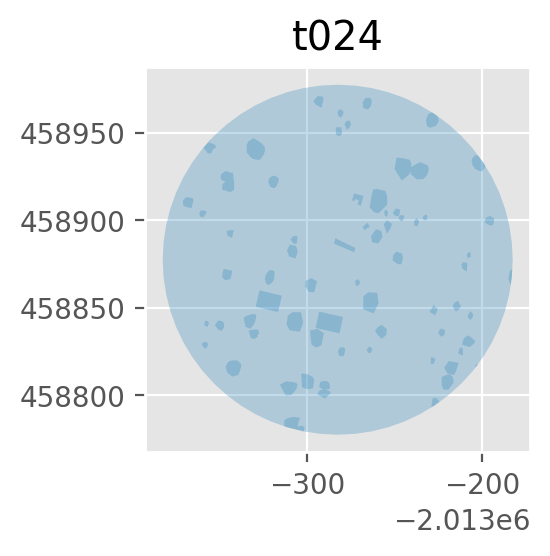

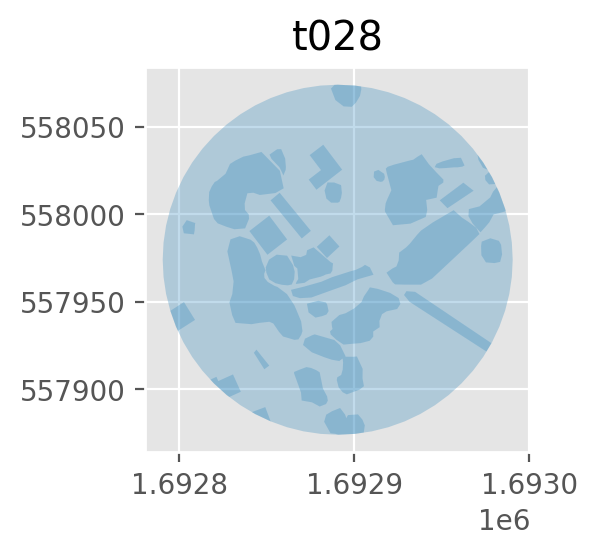

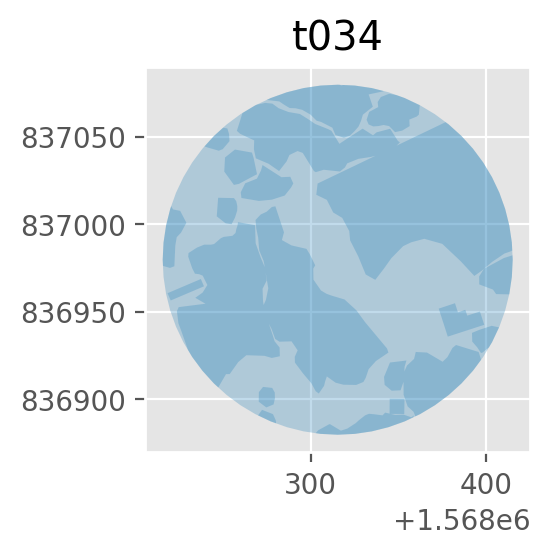

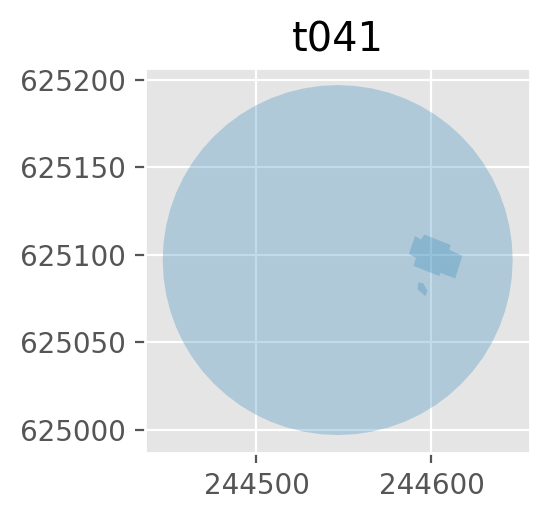

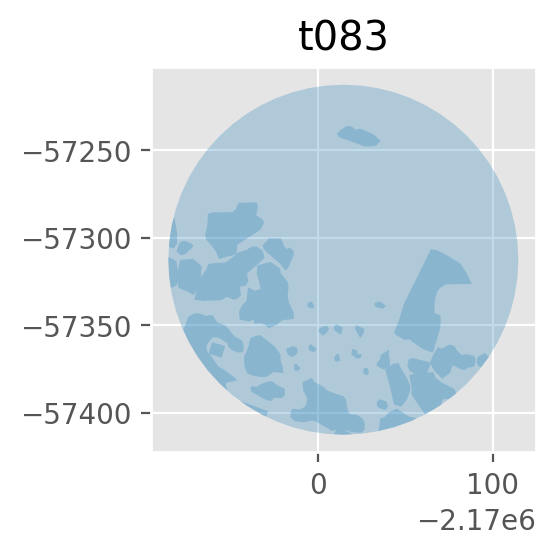

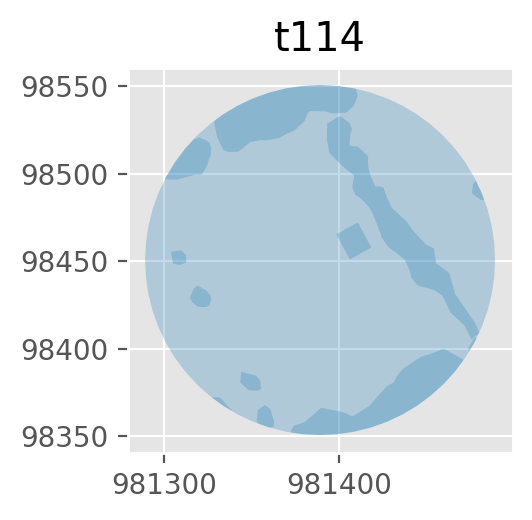

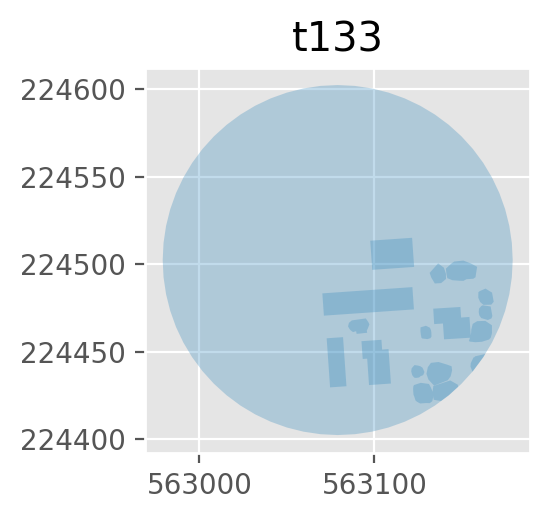

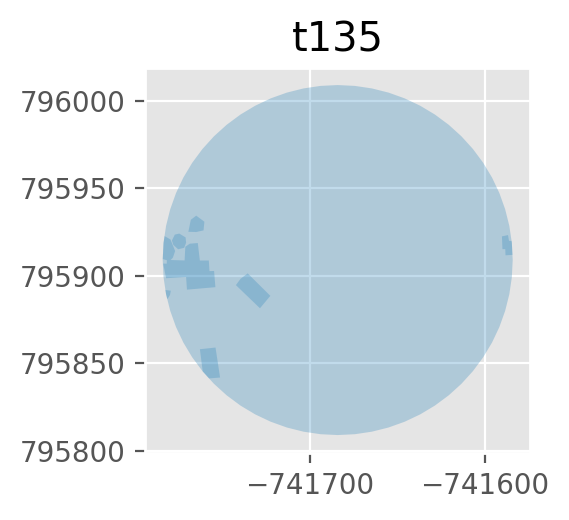

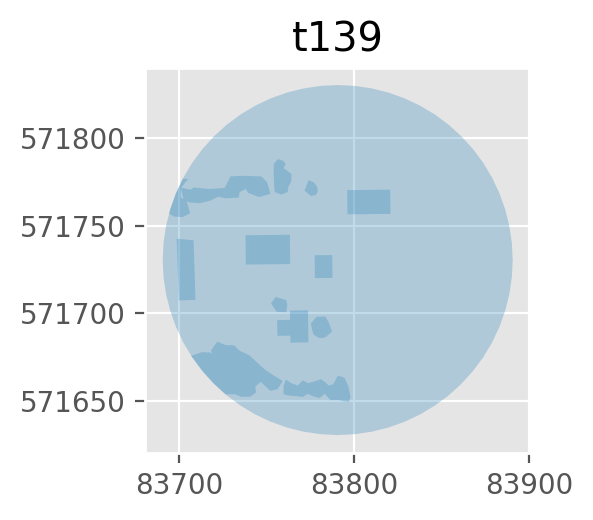

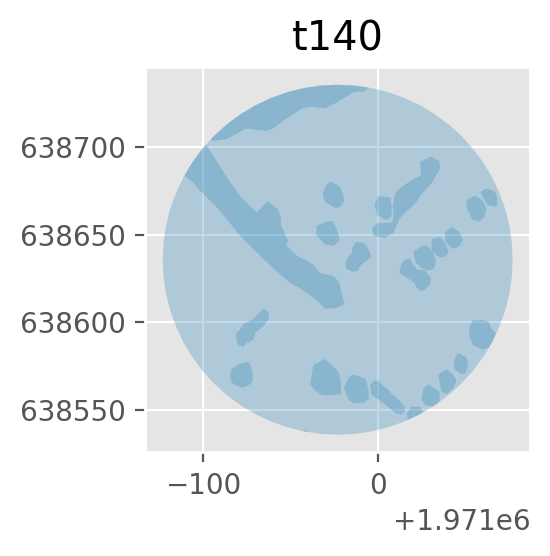

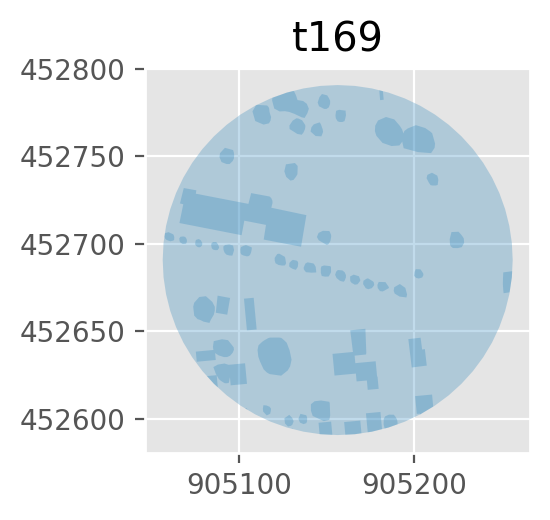

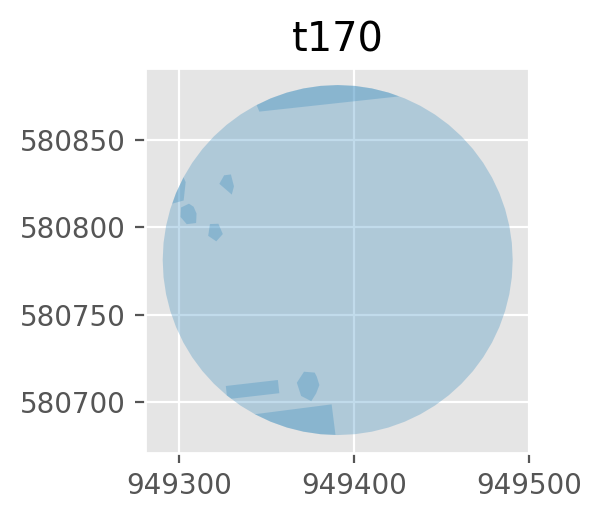

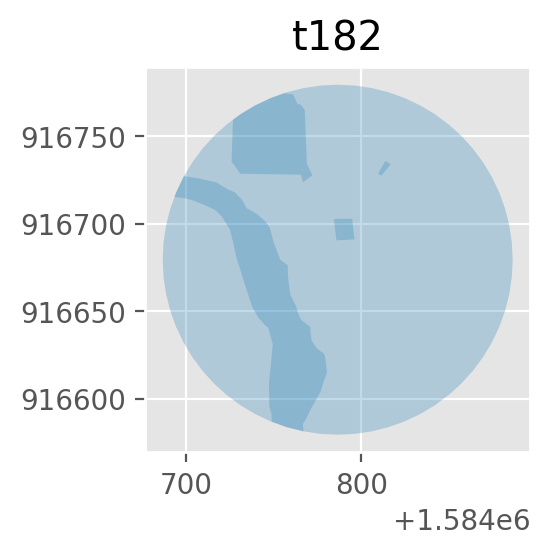

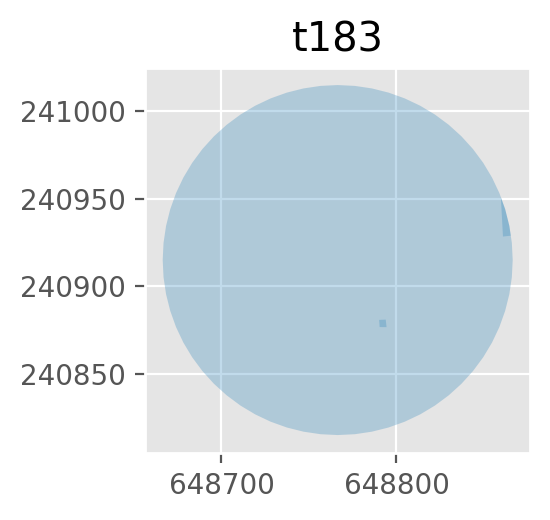

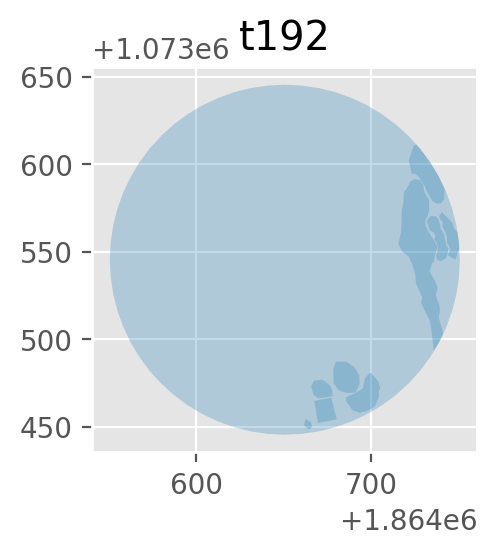

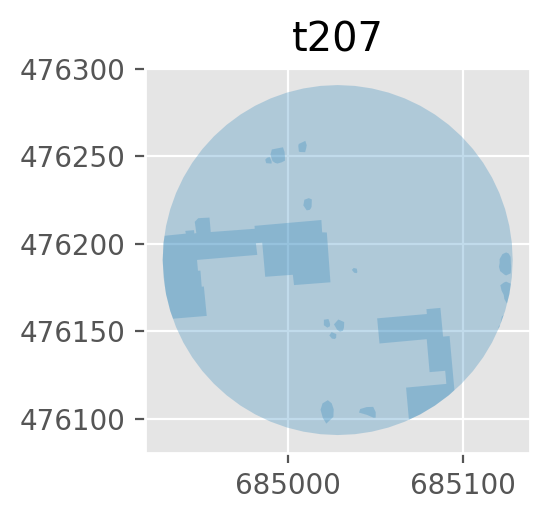

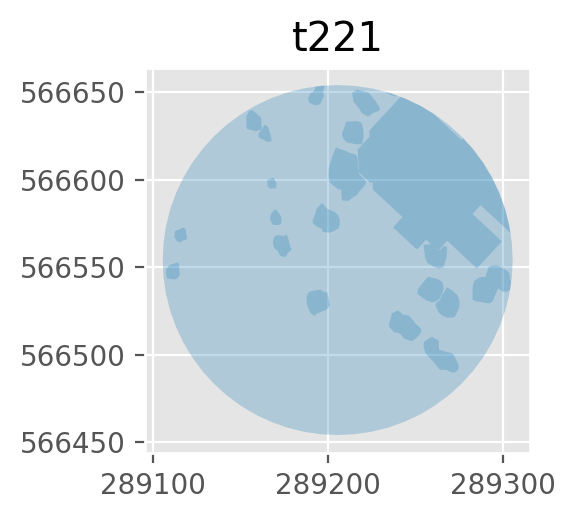

,tid,Number of obstacles (within 100m),Total area of obstacles (within 100m),Site Type
0,t024,66,2278.779673,Rural/Suburban
1,t028,32,9447.097642,Suburban
2,t034,17,19659.716242,Rural
3,t041,2,502.511100,Rural
4,t083,29,7275.820331,Rural
5,t114,12,6084.976293,Rural/Suburban
6,t133,15,2977.200671,Rural
7,t135,7,1010.011273,Rural
8,t139,13,3608.089501,Rural
9,t140,24,6086.883852,Suburban


In [7]:
obstacle_specs = pd.DataFrame(columns=["tid", \
                                       "Number of obstacles (within 100m)", \
                                       "Total area of obstacles (within 100m)", \
                                       "Site Type"])
for tid in selected:
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    if os.path.exists(obstacle_data_file):
        obstacle_df = filter_obstacles(gpd.read_file(obstacle_data_file))
        
        row = index[index["APRS ID"] == tid].iloc[0]
        lat = row["Latitude"]
        lon = row["Longitude"]
        turbine_point = Point(_LatLon_To_XY(lat, lon))
        turbine_point_100m = turbine_point.buffer(100)
        stype = row["Site Type"]

        # This will overwrite lat/lon's with coords in meters (for distance calculation)
        for idx, row in obstacle_df.iterrows():
            obstacle_df.at[idx, "geometry"] = Polygon([Point(_LatLon_To_XY(p[1], p[0])) for p in row["geometry"].exterior.coords])
        #display(obstacle_df)
        
        u = unary_union([p.intersection(turbine_point_100m) for p in obstacle_df.geometry])
        boundary = gpd.GeoSeries(u)
        boundary[1] = turbine_point_100m
        boundary.plot(alpha=0.3, figsize=(2.5, 2.5)).set_title(tid)
        plt.show()
        
        if type(u) == MultiPolygon:
            obstacle_count = len(u.geoms)
        else:
            # assume single polygon
            obstacle_count = 1
        obstacle_specs.loc[len(obstacle_specs)] = [tid, obstacle_count, u.area, stype]
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)

display(obstacle_specs)

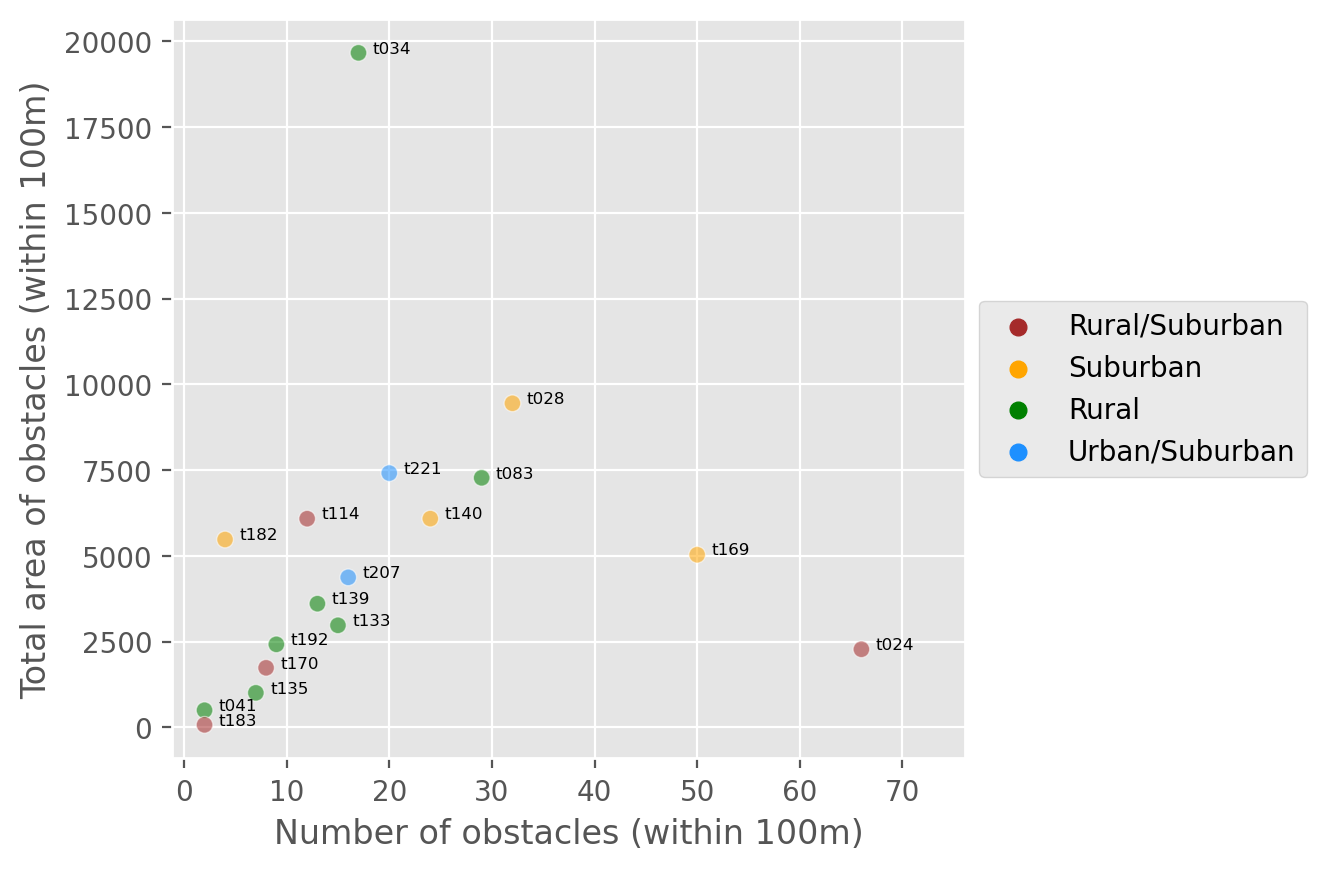

In [8]:
plt.style.use('ggplot')

sns.scatterplot(data=obstacle_specs, \
                x="Number of obstacles (within 100m)", \
                y="Total area of obstacles (within 100m)",\
                hue="Site Type",
                alpha=0.55,
                palette=['brown', 'orange', 'green','dodgerblue']
               );

def label_points(x, y, val, ax):
    xlim = ax.get_xlim()[1]
    offset = xlim / 50  # express offest as a fraction of width
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + offset, point['y'], str(point['val']), fontsize=6.0)
# Increase x axis limit to help include the label for the rightmost point
ax = plt.gca()
label_points(obstacle_specs["Number of obstacles (within 100m)"], \
            obstacle_specs["Total area of obstacles (within 100m)"], \
            obstacle_specs.tid, \
            ax)  
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1] * 1.10);

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()